<a href="https://colab.research.google.com/github/moumahan1990/retail_timeseries_forecasting/blob/master/RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# importing train data to learn
train = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/store.csv",low_memory = False)

In [109]:
train

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1


In [0]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']

In [0]:
# Filter only Store 1 date of Type C for now
train_data = train[train.Store == 1]
#Remove opened stores with zero sales
train_data = train_data[(train_data["Open"] != 0) & (train_data['Sales'] != 0)]

In [37]:
train_data=train_data.sort_index()
train_data=train_data.fillna(0)
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [0]:
train_data["StateHoliday"] = train_data["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

In [0]:
# features = ['Month', 'Day', 'WeekOfYear','DayOfWeek' , 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'SalePerCustomer']
features = ['Month', 'Day', 'WeekOfYear','DayOfWeek' , 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
train_data_X = train_data[features]

In [0]:
train_data_y = train_data[['Sales']]

In [41]:
print("Shape of data:",train_data_X.shape,train_data_y.shape)

Shape of data: (781, 8) (781, 1)


In [0]:
#Prepare train test split
X_train = train_data_X.head(730)
X_test = train_data_X.tail(50)
y_train = train_data_y.head(730)
y_test = train_data_y.tail(50)

X_train = train_data_X[300:-100]
X_test = train_data_X.tail(50)
y_train = train_data_y[300:-100]
y_test = train_data_y.tail(50)

In [0]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(train_data_X, train_data_y, test_size=0.10, random_state=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ff5433d68>]],
      dtype=object)

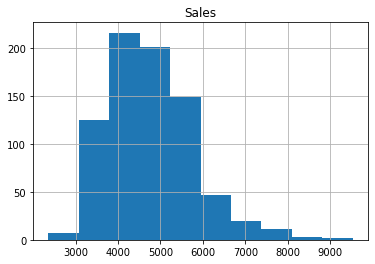

In [114]:
train_data_y.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ff53a3550>]],
      dtype=object)

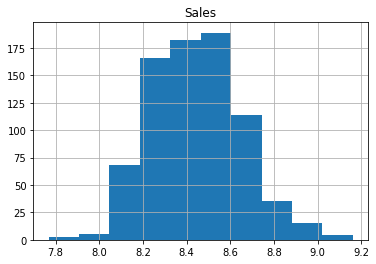

In [115]:
y1 = np.log1p(train_data_y)
y1.hist()

In [0]:
y_train_log = np.log1p(y_train).values

In [103]:
from sklearn.ensemble import RandomForestRegressor

clf_RF = RandomForestRegressor(n_estimators = 15,max_depth = 10,criterion = "mae")
clf_RF.fit(X_train, y_train_log)
# validation
y_pred = clf_RF.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


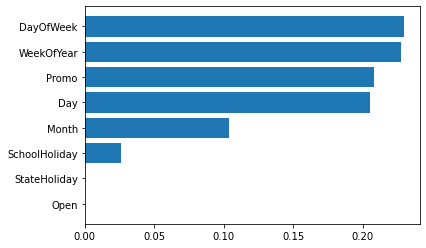

In [106]:
def plot_importance(model):
    k = list(zip(features, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(features)), vals, align='center')
    plt.yticks(np.arange(len(features)), labels)
plot_importance(clf_RF)

In [105]:
#RMSE,MAPE,MAE
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse_rf = sqrt(mean_squared_error(y_test, np.expm1(y_pred)))
MAPE= np.mean(np.abs((y_test.Sales- np.expm1(y_pred)) / y_test.Sales)) * 100
print("MAPE: ",MAPE)
print("MAE: ", mean_absolute_error(y_test.Sales, np.expm1(y_pred)))
print("RMSE: ",rmse_rf)

def MASE(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d
def smape(actual, predicted):
    # return 100/len(test) * np.sum(2 * np.abs(pred - test) / (np.abs(test) + np.abs(pred)))
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

print("MASE",MASE(y_train.Sales,y_test.Sales,np.expm1(y_pred)))
print("SMAPE",smape(y_test.Sales,np.expm1(y_pred)))

MAPE:  7.555061899428515
MAE:  328.1955402713902
RMSE:  421.4152957516909
MASE 0.5616572405982889
SMAPE 0.0727609002654073
